In [178]:
import sys
sys.path.append('../')
import sqlite3
import json
from backtester import *
from fxcmtoken import major_forex_pairs
from sklearn.model_selection import train_test_split
from datetime import datetime
major_forex_pairs

['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CHF', 'USD/CAD', 'AUD/USD', 'NZD/USD']

In [193]:
freq = 'm15'
conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
ticker = major_forex_pairs[6]
print(ticker)
data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
conn.close()

columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)

print(data.shape)
test_size = 0.048 # m15
# test_size = 0.1459
# test_size = 0.144 # m5
test_len = int(test_size * len(data))
print("test length", test_len)
# train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
# data = train_data
# data = test_data
# print(data.shape)
display(data)

NZD/USD
(10000, 13)
test length 480


,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-20 09:30:00,0.69119,0.69141,0.69150,0.69074,0.69139,0.69160,0.69171,0.69094,1418,0.691290,0.691605,0.690840,0.691505
2021-07-20 09:45:00,0.69141,0.69050,0.69157,0.69034,0.69160,0.69069,0.69177,0.69053,1981,0.691505,0.691670,0.690435,0.690595
2021-07-20 10:00:00,0.69050,0.69061,0.69096,0.68977,0.69069,0.69080,0.69113,0.68996,2029,0.690595,0.691045,0.689865,0.690705
2021-07-20 10:15:00,0.69061,0.69050,0.69099,0.69002,0.69080,0.69071,0.69117,0.69020,1986,0.690705,0.691080,0.690110,0.690605
2021-07-20 10:30:00,0.69050,0.69062,0.69072,0.69019,0.69071,0.69080,0.69092,0.69037,1228,0.690605,0.690820,0.690280,0.690710
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-10 20:45:00,0.67948,0.67964,0.67969,0.67942,0.67968,0.67984,0.67990,0.67962,541,0.679580,0.679795,0.679520,0.679740
2021-12-10 21:00:00,0.67965,0.67971,0.67977,0.67958,0.67985,0.67991,0.67997,0.67978,391,0.679750,0.679870,0.679680,0.679810
2021-12-10 21:15:00,0.67970,0.67980,0.67981,0.67966,0.67989,0.68000,0.68004,0.67987,156,0.679795,0.679925,0.679765,0.679900


In [194]:
# data = data.iloc[-1000:]
# data

In [195]:
with open(f'../ta_optimize/json/OPTIMIZE_params_{freq}_100_10_negative.json', 'r') as f:
    parameters = json.load(f)
    
for k, v in parameters.items():
    print(k, v[ticker])

ThreeEMA [10, 20, 30]
ThreeKAMA [10, 20, 40]
ThreeMIDPOINT [10, 20, 30]
ThreeMIDPRICE [10, 20, 30]
ThreeSMA [10, 30, 60]
ThreeTRIMA [10, 20, 30]
ThreeWMA [20, 30, 60]


In [196]:
indicators = {
    'ThreeSMA' : talib.SMA, 
    'ThreeEMA' : talib.EMA,  
    'ThreeKAMA' : talib.KAMA, 
    'ThreeMIDPOINT' : talib.MIDPOINT, 
    'ThreeMIDPRICE' : talib.MIDPRICE, 
    'ThreeTRIMA' : talib.TRIMA, 
    'ThreeWMA' : talib.WMA,
             }

for name, func in indicators.items():
    params = parameters[name][ticker]
    for i in range(len(params)):
        d0 = datetime.now()
        if name == 'ThreeMIDPRICE':
            data[f"{name}_{i+1}"] = func(data['high'], data['low'], params[i])
        else:
            data[f"{name}_{i+1}"] = func(data['close'], params[i])
        print(f"{name} : {datetime.now() - d0}")
print(data.isna().sum().max())        

if data.shape[0] > test_len:
    data = data.iloc[-test_len:]
else:
    pass

# data = data.loc[:'2021-11-19']

ThreeSMA : 0:00:00.004684
ThreeSMA : 0:00:00.004464
ThreeSMA : 0:00:00.002408
ThreeEMA : 0:00:00.001786
ThreeEMA : 0:00:00.001547
ThreeEMA : 0:00:00.001351
ThreeKAMA : 0:00:00.001281
ThreeKAMA : 0:00:00.001271
ThreeKAMA : 0:00:00.001178
ThreeMIDPOINT : 0:00:00.001304
ThreeMIDPOINT : 0:00:00.001964
ThreeMIDPOINT : 0:00:00.001768
ThreeMIDPRICE : 0:00:00.001226
ThreeMIDPRICE : 0:00:00.001187
ThreeMIDPRICE : 0:00:00.001302
ThreeTRIMA : 0:00:00.000977
ThreeTRIMA : 0:00:00.001423
ThreeTRIMA : 0:00:00.001035
ThreeWMA : 0:00:00.000961
ThreeWMA : 0:00:00.001144
ThreeWMA : 0:00:00.001086
59


In [197]:
data.dropna(axis=0, inplace= True)
signal_col = []
for name in indicators.keys():
    data[f"{name}_signal"] = np.where(np.all([data[f"{name}_1"] > data[f"{name}_2"], 
                                              data[f"{name}_2"] > data[f"{name}_3"]], axis=0), 1,
                             np.where(np.all([data[f"{name}_1"] < data[f"{name}_2"], 
                                              data[f"{name}_2"] < data[f"{name}_3"]], axis=0), -1, 0)) 
    # ffill NA --> avoid 2 statistic mode(s)
#     data[f"{name}_signal"] = data[f"{name}_signal"].ffill().fillna(0)
    signal_col.append(f"{name}_signal")
print(signal_col)

signals = data[signal_col].mode(axis=1)[0] * -1
display(signals)
print(data.shape)
print(signals.shape)

['ThreeSMA_signal', 'ThreeEMA_signal', 'ThreeKAMA_signal', 'ThreeMIDPOINT_signal', 'ThreeMIDPRICE_signal', 'ThreeTRIMA_signal', 'ThreeWMA_signal']


date
2021-12-05 22:00:00   -0.0
2021-12-05 22:15:00   -0.0
2021-12-05 22:30:00   -0.0
2021-12-05 22:45:00   -0.0
2021-12-05 23:00:00   -0.0
                      ... 
2021-12-10 20:45:00   -1.0
2021-12-10 21:00:00   -1.0
2021-12-10 21:15:00   -1.0
2021-12-10 21:30:00   -1.0
2021-12-10 21:45:00   -1.0
Name: 0, Length: 480, dtype: float64

(480, 41)
(480,)


In [198]:
print('*** Positions ***')
print(signals.value_counts())
print('-'*50)
print('*** Trades ***')
print(signals.diff(1).apply(np.abs).value_counts())

*** Positions ***
-1.0    199
-0.0    151
 1.0    130
Name: 0, dtype: int64
--------------------------------------------------
*** Trades ***
0.0    434
1.0     45
Name: 0, dtype: int64


  0%|          | 0/479 [00:00<?, ?it/s]

*** NZD/USD ***


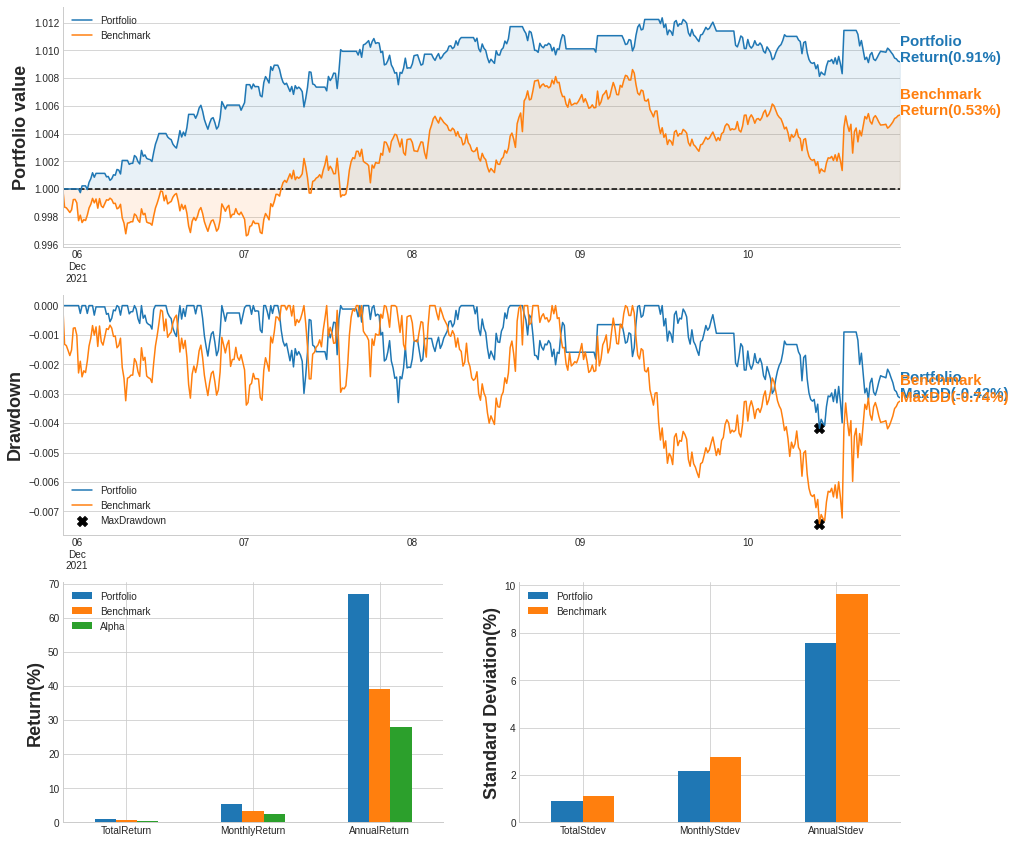

----------------------------------------------------------------------
Data length: |4 days 23:45:00|
Data range from |2021-12-05 22:00:00| to |2021-12-10 21:45:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │       0.916 │       0.534 │   0.383 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │       5.509 │       3.208 │   2.301 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      67.032 │      39.030 │  28.001 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │    

In [199]:
backtester = IterativeBacktester(data=data, freq=freq, signals=signals)
backtester.backtest(leave=False)
print(f"*** {ticker} ***")
backtester.results()

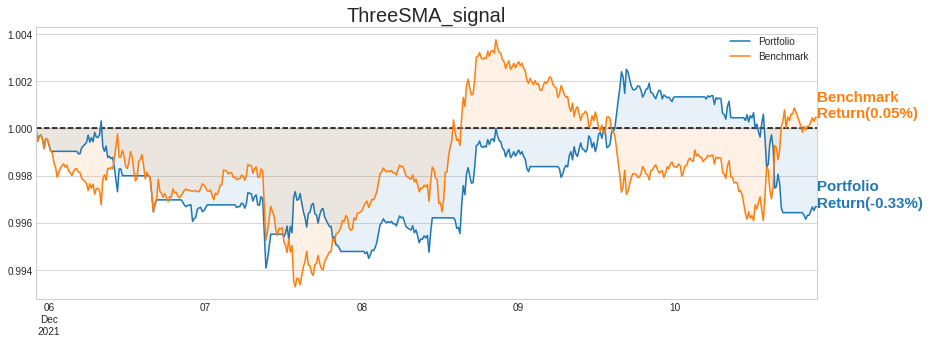

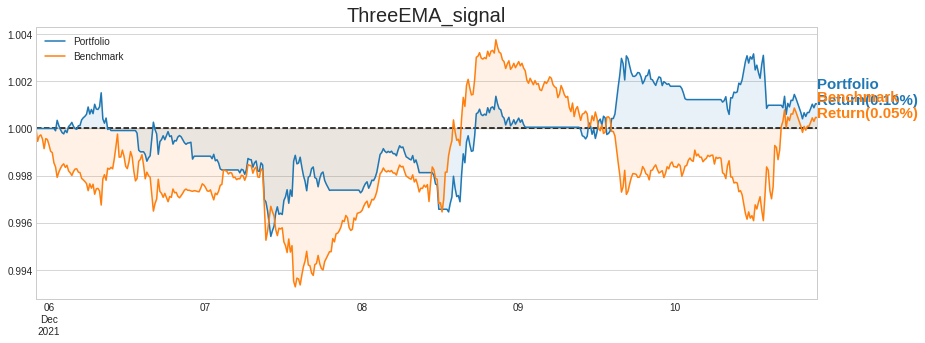

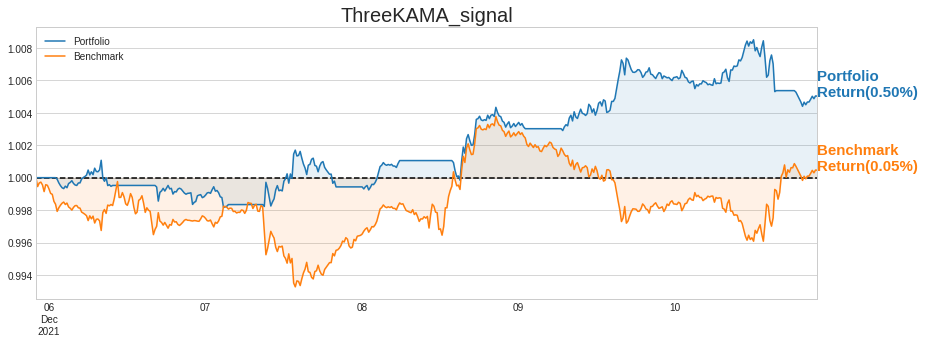

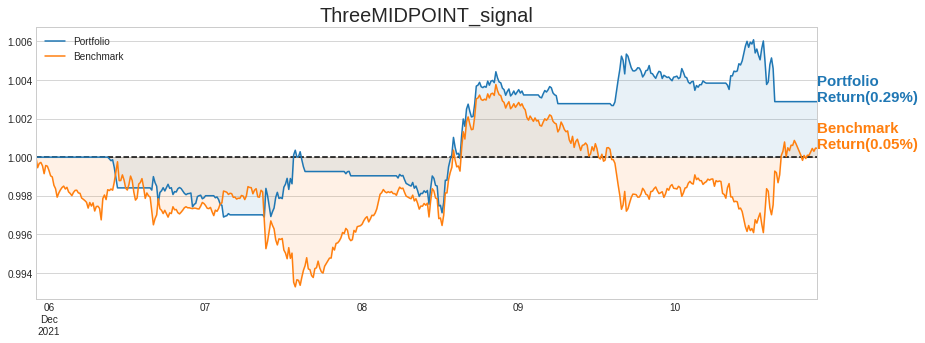

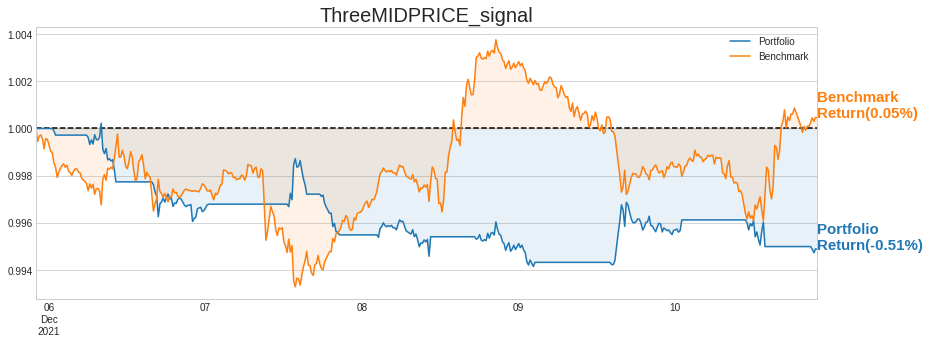

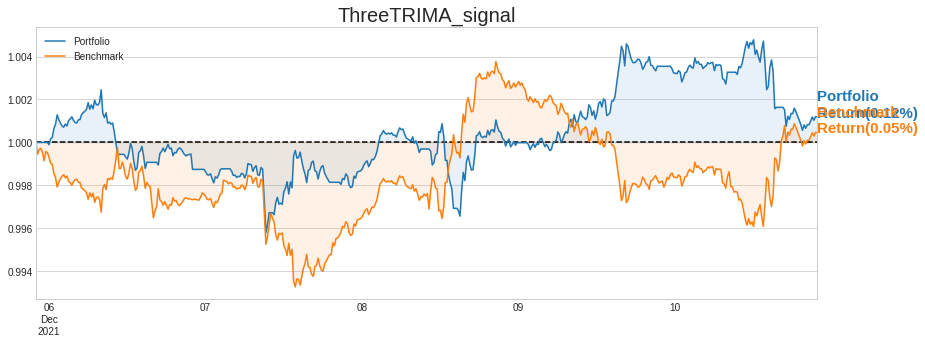

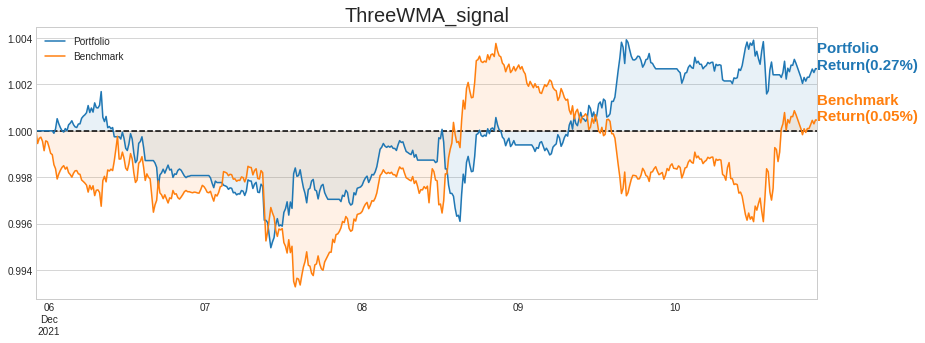

In [186]:
for sign in signal_col:
    backtest = IterativeBacktester(data, data[sign], freq)
    backtest.backtest(progress_bar=False)
    # print(sign)
    backtest.portfolio_df[['Portfolio', 'Benchmark']].plot(color=['tab:blue', 'tab:orange'], xlabel='', figsize=(14,5))
    plt.title(sign, fontsize=20)
    plt.hlines(backtest.init_money, xmin=backtest.portfolio_df.index[0], xmax=backtest.portfolio_df.index[-1], color='k', linestyle='--')
    plt.fill_between(x=backtest.portfolio_df.index, y1=backtest.portfolio_df['Portfolio'], y2=backtest.init_money, color='tab:blue', alpha=0.1)
    plt.fill_between(x=backtest.portfolio_df.index, y1=backtest.portfolio_df['Benchmark'], y2=backtest.init_money, color='tab:orange', alpha=0.1)
    plt.text(backtest.portfolio_df.index[-1], backtest.portfolio_df['Portfolio'][-1], f"Portfolio\nReturn({backtest.portfolio_df['PortfolioReturns'].sum()*100:.2f}%)", color="tab:blue", fontsize=15, fontweight="heavy")
    plt.text(backtest.portfolio_df.index[-1], backtest.portfolio_df['Benchmark'][-1], f"Benchmark\nReturn({backtest.portfolio_df['BenchmarkReturns'].sum()*100:.2f}%)", color="tab:orange", fontsize=15, fontweight="heavy")

In [222]:
def forex_backtest():
    major_forex_pairs = ['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CHF', 'USD/CAD', 'AUD/USD', 'NZD/USD']
    returns = []
    for pair in tqdm_notebook(major_forex_pairs, leave=False):
        freq = 'm15'
        conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
        ticker = pair
        data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
        conn.close()
        columns = ['open', 'high', 'low', 'close']
        for col in columns:
            data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
        test_size = 0.048 # m15
#         test_size = 0.1459
        test_len = int(test_size * len(data))

        with open(f'../ta_optimize/json/OPTIMIZE_params_{freq}_500_50_negative.json', 'r') as f:
            parameters = json.load(f)

        indicators = {
            'ThreeSMA' : talib.SMA, 
            'ThreeEMA' : talib.EMA,  
            'ThreeKAMA' : talib.KAMA, 
            'ThreeMIDPOINT' : talib.MIDPOINT, 
            'ThreeMIDPRICE' : talib.MIDPRICE, 
            'ThreeTRIMA' : talib.TRIMA, 
            'ThreeWMA' : talib.WMA,
                     }

        for name, func in indicators.items():
            params = parameters[name][ticker]
            for i in range(len(params)):
                d0 = datetime.now()
                if name == 'ThreeMIDPRICE':
                    data[f"{name}_{i+1}"] = func(data['high'], data['low'], params[i])
                else:
                    data[f"{name}_{i+1}"] = func(data['close'], params[i])

        if data.shape[0] > test_len:
            data = data.iloc[-test_len:]
        else:
            pass
        
        ##### Don't forget this! ##### 
#         data = data.loc[:'2021-11-19']
#         display(data)
#         break 
        data.dropna(axis=0, inplace= True)
        signal_col = []
        for name in indicators.keys():
            data[f"{name}_signal"] = np.where(np.all([data[f"{name}_1"] > data[f"{name}_2"], 
                                                      data[f"{name}_2"] > data[f"{name}_3"]], axis=0), 1,
                                     np.where(np.all([data[f"{name}_1"] < data[f"{name}_2"], 
                                                      data[f"{name}_2"] < data[f"{name}_3"]], axis=0), -1, 0))            # ffill NA --> avoid 2 statistic mode(s)
#             data[f"{name}_signal"] = data[f"{name}_signal"].ffill().fillna(0)
            signal_col.append(f"{name}_signal")

        signals = data[signal_col].mode(axis=1)[0] *-1

        backtester = IterativeBacktester(data=data, freq=freq, signals=signals)
        backtester.backtest(leave=False)
        ret = backtester.return_df.loc['TotalReturn', 'Portfolio']
        returns.append(ret)
        print(f"{ret}")
    print("-"*30)
    print(f"{np.mean(returns)*100:.2f}%")

In [223]:
forex_backtest()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

0.008760231411157253


  0%|          | 0/479 [00:00<?, ?it/s]

0.0013614122145349595


  0%|          | 0/479 [00:00<?, ?it/s]

0.003256148625196548


  0%|          | 0/479 [00:00<?, ?it/s]

0.015478333202547398


  0%|          | 0/479 [00:00<?, ?it/s]

-0.008957448433514703


  0%|          | 0/479 [00:00<?, ?it/s]

-0.0002544471179799037


  0%|          | 0/479 [00:00<?, ?it/s]

0.005162788474210927
------------------------------
0.35%
